In [1]:
import matplotlib.pyplot as plt
%matplotlib inline  
%load_ext autoreload
%autoreload 2
import numpy as np
import time
import random
def print_np(x):
    print ("Type is %s" % (type(x)))
    print ("Shape is %s" % (x.shape,))
#     print ("Values are: \n%s" % (x))

In [2]:
import cvxpy
print(cvxpy.installed_solvers())

['CPLEX', 'ECOS', 'ECOS_BB', 'MOSEK', 'OSQP', 'SCIPY', 'SCS']


In [3]:
import sys
# sys.path.append('../')
sys.path.append('../')
sys.path.append('../model')
sys.path.append('../cost')
sys.path.append('../constraints')
import UnicycleModel
import FinaltimeFreeCost
import UnicycleConstraints
from scipy.integrate import solve_ivp
from SCP_buffer_deviation import SCP_buffer_deviation
from Scaling import TrajectoryScaling

In [4]:
ix = 3
iu = 2
ih = 2
N = 50
tf = 40
delT = tf/N
max_iter = 20

In [5]:
myModel = UnicycleModel.unicycle('Hello',ix,iu,'numeric_central')
myCost = FinaltimeFreeCost.Finaltime('Hello',ix,iu,N)
myConst = UnicycleConstraints.UnicycleConstraints('Hello',ix,iu)

x_min = np.zeros(ix)
x_max = np.array([2,2,np.pi])
# x_max = np.ones(ix)
u_min = np.zeros(iu)
u_max = np.array([0.2,np.deg2rad(5)])
# u_max = np.ones(iu)

myScaling = TrajectoryScaling(x_min,x_max,u_min,u_max,tf)

In [6]:
xi = np.zeros(3)
xi[0] = -2.0
xi[1] = -2.0 
xi[2] = 0

xf = np.zeros(3)
xf[0] = 2.0
xf[1] = 2.0
xf[2] = 0


x0 = np.zeros((N+1,ix))
for i in range(N+1) :
    x0[i] = (N-i)/N * xi + i/N * xf
u0 = np.ones((N+1,iu))*1e-3
# u0 = np.zeros((N+1,iu))

In [10]:
i1 = SCP_buffer_deviation('unicycle',N,tf,max_iter,myModel,myCost,myConst,myScaling,
          type_discretization="foh",w_c=1e-1,w_bf=1e4,w_bf_b=1e4,w_tr=1e-2,tol_bf=1e-6,tol_tr=1e-5)
x,u,xbar,ubar,Tbar,total_num_iter,flag_boundary,l,l_vc,l_tr,x_traj,u_traj  = i1.run(x0,u0,xi,xf)


iteration   total_cost        cost        ||bf||     ||tr||       reduction   w_tr        bounary
1           78350.501         3.760       7.83        110         -7.83e+04   0.010000    0(5.23)
2           2.793             2.090       3.46e-08    70.3        7.83e+04    0.010000    0(2.17)
non-positive expected reduction
3           3.872             3.719       9.32e-08    15.2        -1.08       0.010000    0(1.47)
4           3.165             3.095       3.87e-08    6.91        0.707       0.010000    0(0.546)
non-positive expected reduction
5           3.322             3.316       4.32e-08    0.473       -0.157      0.010000    0(0.0464)
6           3.315             3.313       4.78e-08    0.141       0.00651     0.010000    0(0.0115)
non-positive expected reduction
7           3.318             3.317       5.02e-08    0.0476      -0.00296    0.010000    0(0.00632)
8           3.317             3.316       5.14e-08    0.0412      0.000729    0.010000    0(0.00804)
9          

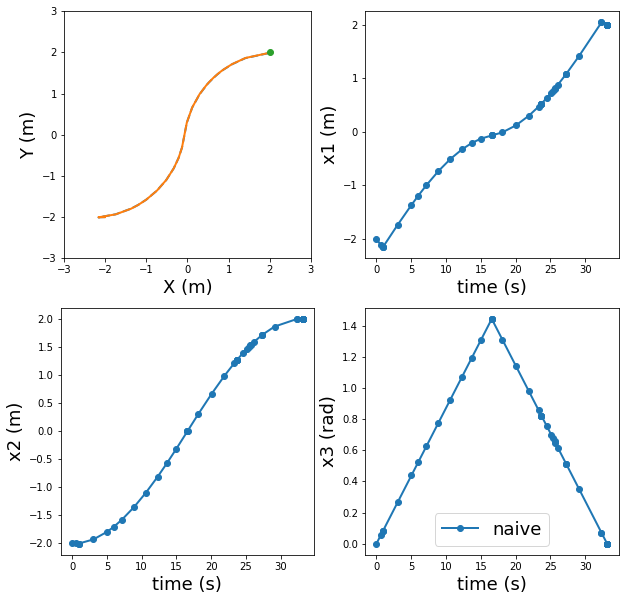

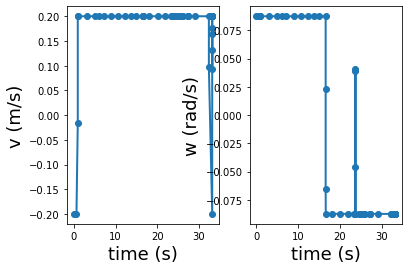

In [11]:
t_index = [np.sum(Tbar[:i])  for i in range(N+1)]
plt.figure(figsize=(10,10))
fS = 18
plt.subplot(221)
plt.plot(x[:,0], x[:,1],'--', linewidth=2.0)
plt.plot(xbar[:,0], xbar[:,1], linewidth=2.0)
plt.plot(xf[0],xf[1],"o",label='goal')
plt.gca().set_aspect('equal', adjustable='box')
plt.axis([-3, 3, -3, 3])
plt.xlabel('X (m)', fontsize = fS)
plt.ylabel('Y (m)', fontsize = fS)
plt.subplot(222)
plt.plot(t_index, x[:,0],'o-', linewidth=2.0,label='naive')
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('x1 (m)', fontsize = fS)
plt.subplot(223)
plt.plot(t_index, x[:,1],'o-', linewidth=2.0,label='naive')
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('x2 (m)', fontsize = fS)
plt.subplot(224)
plt.plot(t_index, x[:,2],'o-', linewidth=2.0,label='naive')
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('x3 (rad)', fontsize = fS)
plt.legend(fontsize=fS)
plt.show()

plt.figure()
plt.subplot(121)
plt.plot(t_index, u[:,0],'o-', linewidth=2.0)
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('v (m/s)', fontsize = fS)
plt.subplot(122)
plt.plot(t_index, u[:,1],'o-', linewidth=2.0)
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('w (rad/s)', fontsize = fS)
plt.show()

In [ ]:
filenames = []
for i in range(N+1) :
    fS = 18
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.plot(x[:i+1,0], x[:i+1,1], linewidth=2.0) 
    plt.plot(xf[0], xf[1],'*', linewidth=2.0)
    plt.plot(x[i,0], x[i,1],'*', linewidth=2.0) 
    plt.plot(x[i,0], x[i,1], marker=(3, 0, x[i,2]*180/np.pi-90), markersize=20, linestyle='None')
#     ax.add_patch(rec)
    plt.axis([-3, 3, -3, 3])
    plt.xlabel('X (m)', fontsize = fS)
    plt.ylabel('Y (m)', fontsize = fS)

    filename = '../images/{:d}.png'.format(i)
    plt.savefig(filename)
    filenames.append(filename)
    plt.close()

In [ ]:
with imageio.get_writer('../images/unicycle.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
for filename in set(filenames):
    os.remove(filename)